In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore", category=RuntimeWarning)
os.chdir(r'C:\Users\신상훈\바탕화면\학과\대학원 1-2\통계적 기계학습\머신러닝')

In [3]:
df = pd.read_csv('income_evaluation.csv')

In [4]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
             'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

df.columns = col_names

df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [5]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 9 categorical variables

The categorical variables are :

 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']


In [6]:
df['workclass'].replace(' ?', np.NaN, inplace=True)

In [7]:
df['occupation'].replace(' ?', np.NaN, inplace=True)

In [8]:
df['native_country'].replace(' ?', np.NaN, inplace=True)

In [9]:
df[categorical].isnull().sum()

workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
native_country     583
income               0
dtype: int64

In [10]:
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
df['native_country'].fillna(df['native_country'].mode()[0], inplace=True) 

In [16]:
from sklearn.preprocessing import LabelEncoder

for var in categorical:
    encoder = LabelEncoder()
    encoder.fit(df[var])
    labels = encoder.transform(df[var])
    df[var] = labels

In [17]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,3,257302,7,12,2,12,5,4,0,0,0,38,38,0
32557,40,3,154374,11,9,2,6,0,4,1,0,0,40,38,1
32558,58,3,151910,11,9,6,0,4,4,0,0,0,40,38,0
32559,22,3,201490,11,9,4,0,3,4,1,0,0,20,38,0


In [18]:
X = df.drop(['income'], axis=1)

y = df['income']

In [19]:
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int32

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [21]:
X_train.shape, X_test.shape

((22792, 14), (9769, 14))

In [23]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country']

In [24]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country']

In [25]:
cols = X_train.columns

In [26]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [27]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [28]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [29]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [30]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [31]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[200],
    'max_depth' : [10,12,14], 
    'min_samples_leaf' : [1 ],
    'min_samples_split' : [12,14,16]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_rf = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_rf.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_rf.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_rf.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 200}
최고 예측 정확도: 0.8617


In [32]:
best_rf = grid_rf.best_estimator_
best_rf.fit(X_train,y_train)
best_pred = best_rf.predict(X_test)
get_model_train_eval(best_rf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[6992  415]
 [ 928 1434]]
정확도: 0.8625, 정밀도: 0.7756, 재현율: 0.6071,    F1: 0.6811, AUC:0.9166


In [36]:
ftr_top

capital_gain      0.190526
relationship      0.170521
education_num     0.140225
marital_status    0.119166
age               0.091170
hours_per_week    0.062936
capital_loss      0.052551
education         0.040376
fnlwgt            0.039921
occupation        0.035141
sex               0.021244
workclass         0.020311
native_country    0.008812
race              0.007100
dtype: float64

In [37]:
cols

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')

In [45]:
ftr1 = ftr_top.reset_index(level = [0]).set_index(['level_0']).index

In [ ]:
ftr_top1 = ['capital_gain','relationship','education_num','marital_status']

<AxesSubplot:title={'center':'Feature importance'}, ylabel='level_0'>

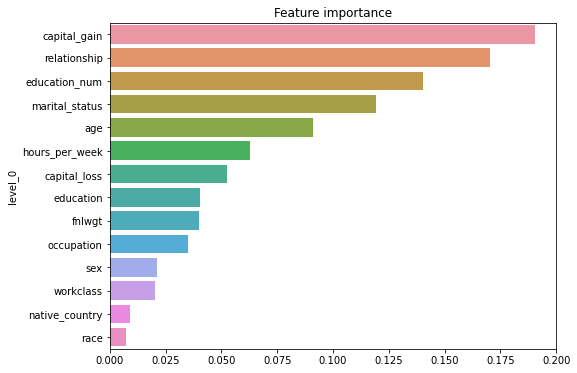

In [46]:
ftr_importance_values = best_rf.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index = X_train.columns)
ftr_top = ftr_importance.sort_values(ascending = False)

plt.figure(figsize = (8,6))
plt.title('Feature importance')
sns.barplot(x = ftr_top, y = ftr1)

## xgboost

In [48]:
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [49]:
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss',
           'early_stoppings':100
        }
num_rounds = 400

In [50]:
wlist = [(dtrain,'train'),(dtest,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , evals=wlist )

[13:07:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.64212	eval-logloss:0.64209
[1]	train-logloss:0.60047	eval-logloss:0.60043
[2]	train-logloss:0.56593	eval-logloss:0.56597
[3]	train-logloss:0.53695	eval-logloss:0.53714
[4]	train-logloss:0.51224	eval-logloss:0.51249
[5]	train-logloss:0.49123	eval-logloss:0.49163
[6]	train-logloss:0.47324	eval-logloss:0.47373
[7]	train-logloss:0.45752	eval-logloss:0.45825
[8]	train-logloss:0.44382	eval-logloss:0.44459
[9]	train-logloss:0.43100	eval-logloss:0.43185
[10]	train-logloss:0.42044	eval-logloss:0.42163
[11]	train-logloss:0.41096	eval-logloss:0.41237
[12]	train-logloss:0.40256	eval-logloss:0

[162]	train-logloss:0.27549	eval-logloss:0.28847
[163]	train-logloss:0.27540	eval-logloss:0.28839
[164]	train-logloss:0.27533	eval-logloss:0.28837
[165]	train-logloss:0.27526	eval-logloss:0.28829
[166]	train-logloss:0.27522	eval-logloss:0.28827
[167]	train-logloss:0.27501	eval-logloss:0.28806
[168]	train-logloss:0.27485	eval-logloss:0.28800
[169]	train-logloss:0.27470	eval-logloss:0.28791
[170]	train-logloss:0.27460	eval-logloss:0.28788
[171]	train-logloss:0.27452	eval-logloss:0.28786
[172]	train-logloss:0.27426	eval-logloss:0.28762
[173]	train-logloss:0.27420	eval-logloss:0.28759
[174]	train-logloss:0.27408	eval-logloss:0.28753
[175]	train-logloss:0.27394	eval-logloss:0.28747
[176]	train-logloss:0.27388	eval-logloss:0.28744
[177]	train-logloss:0.27372	eval-logloss:0.28730
[178]	train-logloss:0.27366	eval-logloss:0.28726
[179]	train-logloss:0.27362	eval-logloss:0.28723
[180]	train-logloss:0.27352	eval-logloss:0.28717
[181]	train-logloss:0.27346	eval-logloss:0.28712
[182]	train-logloss:

[330]	train-logloss:0.26117	eval-logloss:0.28256
[331]	train-logloss:0.26110	eval-logloss:0.28253
[332]	train-logloss:0.26101	eval-logloss:0.28243
[333]	train-logloss:0.26090	eval-logloss:0.28239
[334]	train-logloss:0.26080	eval-logloss:0.28236
[335]	train-logloss:0.26072	eval-logloss:0.28232
[336]	train-logloss:0.26065	eval-logloss:0.28234
[337]	train-logloss:0.26056	eval-logloss:0.28235
[338]	train-logloss:0.26054	eval-logloss:0.28235
[339]	train-logloss:0.26047	eval-logloss:0.28234
[340]	train-logloss:0.26040	eval-logloss:0.28234
[341]	train-logloss:0.26034	eval-logloss:0.28235
[342]	train-logloss:0.26023	eval-logloss:0.28233
[343]	train-logloss:0.26018	eval-logloss:0.28231
[344]	train-logloss:0.26015	eval-logloss:0.28230
[345]	train-logloss:0.26014	eval-logloss:0.28228
[346]	train-logloss:0.26009	eval-logloss:0.28224
[347]	train-logloss:0.26001	eval-logloss:0.28226
[348]	train-logloss:0.25991	eval-logloss:0.28226
[349]	train-logloss:0.25981	eval-logloss:0.28222
[350]	train-logloss:

In [51]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.016 0.028 0.164 0.454 0.351 0.202 0.038 0.075 0.136 0.   ]
예측값 10개만 표시: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[6963  444]
 [ 837 1525]]
정확도: 0.8689, 정밀도: 0.7745, 재현율: 0.6456,    F1: 0.7042, AUC:0.9268


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

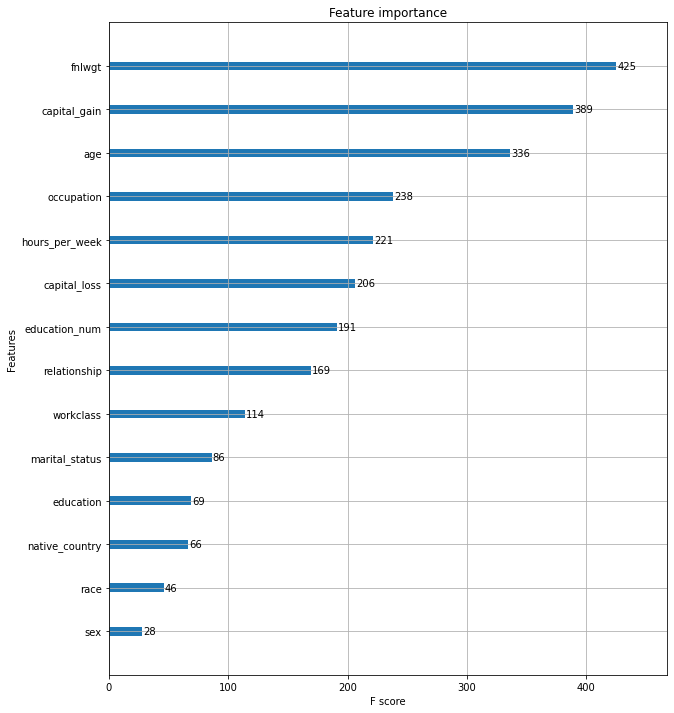

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)